# Interpreting CNN Results

In this tutorial, we will create a model to distinguish images from Alzheimer's patients and normal subjects. Then, we will employ a method called GRAD-CAM to try to interpret the results and arrive to a conclusion on whether the results make sense or not.


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

In [2]:
# Loading the datasets
ad = np.load("../Data/Alzheimer/alzheimer_4_slices_240_180_philips_3t.npy") # Alzheimer's
normal = np.load("../Data/Alzheimer/normal_4_slices_256_212_ge_3t.npy") # Normal

# Padding images to the same dimensions
new_dims = 256,256
ad_resized = np.zeros((ad.shape[0],new_dims[0],new_dims[1]), dtype = np.float32)
ad_resized[:,:ad.shape[1],:ad.shape[2]] = ad

normal_resized = np.zeros((normal.shape[0],new_dims[0],new_dims[1]), dtype = np.float32)
normal_resized[:,:normal.shape[1],:normal.shape[2]] = normal

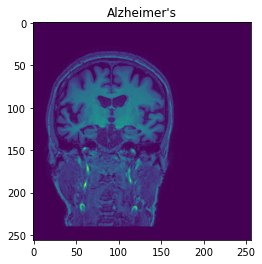

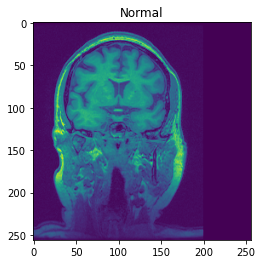

In [3]:
plt.figure()
plt.imshow(ad_resized[10])
plt.title("Alzheimer's")
plt.show()

plt.figure()
plt.imshow(normal_resized[10])
plt.title("Normal")
plt.show()

In [4]:
# Concatenating the data
X = np.concatenate((normal_resized,ad_resized), axis = 0)
Y = np.zeros(X.shape[0])
Y[Y.shape[0]//2:] = 1


# Train/Validation/Test split
nslices = 4
indexes = np.arange(Y.shape[0]//nslices, dtype = int)
np.random.shuffle(indexes)
train = indexes[:int(0.6*indexes.shape[0])]*nslices
train = np.repeat(train,nslices).reshape(-1,nslices) + np.arange(nslices)# 60%
val = indexes[int(0.6*indexes.shape[0]):int(0.8*indexes.shape[0])]*nslices # 20%
val = np.repeat(val,nslices).reshape(-1,nslices) + np.arange(nslices)
test = indexes[int(0.8*indexes.shape[0]):]*nslices # 20%
test = np.repeat(test,nslices).reshape(-1,nslices) + np.arange(nslices)
train = train.flatten()
val = val.flatten()
test = test.flatten()

# Train and validation split
X_train = X[train]
Y_train = Y[train]
X_val = X[val]
Y_val = Y[val]
X_test = X[test]
Y_test = Y[test]

print("\nTrain set")
print("Images: ",X_train.shape)
print("Labels shape: ",Y_train.shape)
print("\nValidation set")
print("Images: ",X_val.shape)
print("Labels shape: ",Y_val.shape)


Train set
Images:  (288, 256, 256)
Labels shape:  (288,)

Validation set
Images:  (96, 256, 256)
Labels shape:  (96,)


In [5]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())
print(X_val.min(),X_val.max(),X_val.mean(),X_val.std())

0.0 1.0 0.10407016 0.13621856
0.0 1.0 0.09929351 0.13363117


In [6]:
# Defining a simple CNN model
ishape = (256,256,1)
lr = 1e-3
model_input = tf.keras.layers.Input(shape = ishape)
l1 = tf.keras.layers.Conv2D(48, (3,3), activation='relu')(model_input)
l2 = tf.keras.layers.Conv2D(48, (3,3),  activation='relu')(l1)
l2_drop = tf.keras.layers.Dropout(0.3)(l2)
l3 = tf.keras.layers.MaxPool2D((2,2))(l2_drop)

l4 = tf.keras.layers.Conv2D(96, (3,3),  activation='relu')(l3)
l5 = tf.keras.layers.Conv2D(96, (3,3),  activation='relu')(l4)
l5_drop = tf.keras.layers.Dropout(0.5)(l5)
l6 = tf.keras.layers.MaxPool2D((2,2))(l5_drop)

l7 = tf.keras.layers.Conv2D(192, (3,3),  activation='relu')(l6)
l8 = tf.keras.layers.Conv2D(192, (3,3),  activation='relu')(l7)
l8_drop = tf.keras.layers.Dropout(0.5)(l8)
l9 = tf.keras.layers.MaxPool2D((2,2))(l8_drop)

l10 = tf.keras.layers.Conv2D(384, (3,3),  activation='relu')(l9)
l11 = tf.keras.layers.Conv2D(384, (3,3),  activation='relu')(l10)
l11_drop = tf.keras.layers.Dropout(0.3)(l11)


flat = tf.keras.layers.Flatten()(l11_drop)

out = tf.keras.layers.Dense(1,activation = 'sigmoid')(flat)

model = tf.keras.models.Model(inputs = model_input, outputs = out)

In [7]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss = "binary_crossentropy", metrics = ["accuracy"])

In [8]:
model_name = "best_model_alzheimer_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [9]:
model.fit(X_train[:,:,:,np.newaxis],Y_train,batch_size = 64, epochs = 25, \
          verbose = 1, callbacks= [early_stop, monitor],validation_data=(X_val[:,:,:,np.newaxis],Y_val), shuffle  = True)

Epoch 1/25
5/5 [==============================] - 132s 16s/step - loss: 0.7330 - accuracy: 0.4843 - val_loss: 0.6845 - val_accuracy: 0.8958
Epoch 2/25
5/5 [==============================] - 1s 295ms/step - loss: 0.6969 - accuracy: 0.7180 - val_loss: 0.6905 - val_accuracy: 0.4167
Epoch 3/25
5/5 [==============================] - 1s 294ms/step - loss: 0.4986 - accuracy: 0.6685 - val_loss: 0.3923 - val_accuracy: 0.9583
Epoch 4/25
5/5 [==============================] - 1s 295ms/step - loss: 0.1369 - accuracy: 0.9504 - val_loss: 0.1742 - val_accuracy: 0.9688
Epoch 5/25
5/5 [==============================] - 1s 294ms/step - loss: 0.0322 - accuracy: 0.9803 - val_loss: 0.1396 - val_accuracy: 1.0000
Epoch 6/25
5/5 [==============================] - 1s 293ms/step - loss: 0.0351 - accuracy: 0.9841 - val_loss: 0.0706 - val_accuracy: 1.0000
Epoch 7/25
5/5 [==============================] - 1s 294ms/step - loss: 0.0408 - accuracy: 0.9881 - val_loss: 0.2574 - val_accuracy: 0.9167
Epoch 8/25
5/5 [====

In [10]:
model.load_weights(model_name)
metrics = model.evaluate(X_test[:,:,:,np.newaxis],Y_test)
print("Categorical cross-entropy:", metrics[0])
print("Accuracy:", metrics[1])

3/3 [==============================] - 0s 41ms/step - loss: 0.5030 - accuracy: 0.9583
Categorical cross-entropy: 0.5030455589294434
Accuracy: 0.9583333134651184
